In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
import pickle
import seaborn as sns
import pandas as pd
from scipy import stats
from statannotations.Annotator import Annotator

plt.rcParams.update({'font.size': 12})

# PFI

In [15]:
# Load meg channel config
dataset_path = os.path.join('/',
                            'well',
                            'woolrich',
                            'projects',
                            'cichy118_cont',
                            'raw_data',
                            'subj01',
                            'MEG2_subj01_sess01_tsss_mc-3.fif')
raw = mne.io.read_raw_fif(dataset_path, preload=True)
chn_type = 'mag'
raw = raw.pick(chn_type)

Opening raw data file /well/woolrich/projects/cichy118_cont/raw_data/subj01/MEG2_subj01_sess01_tsss_mc-3.fif...
    Range : 4930000 ... 5162999 =   4930.000 ...  5162.999 secs
Ready.


<ipython-input-15-901adaf23559>:10: RuntimeWarning: This filename (/well/woolrich/projects/cichy118_cont/raw_data/subj01/MEG2_subj01_sess01_tsss_mc-3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(dataset_path, preload=True)


Reading 0 ... 232999  =      0.000 ...   232.999 secs...


In [16]:
# load gradient analysis results
path = os.path.join('..',
                    'results',
                    'cichy_epoched',
                    'all_noshuffle_wavenetclass_semb10_drop0.4',
                    'grads.npy')

grads = np.load(path)
pfi = np.abs(grads).transpose(0, 2, 1)
pfits = np.mean(pfi, axis=2)

# convolve pfits with summation kernel
kernel = np.ones(24) / 24

# use convolution which operates on last axis
pfits = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), -1, pfits)

time_range = np.arange(-100, 924, 4)

In [ ]:
pfits.shape

In [30]:
# load pfi data
path = os.path.join('..', 'results', 'cichy_epoched', 'all_noshuffle_wavenetclass_semb10_drop0.4', 'groupPFI',
                    'val_loss_PFIch4.npy')
pfi = np.load(open(path, 'rb'))
pfi = pfi[0, 0, 0] - pfi[:, :, 1:]

time_range = np.arange(-48, 872, 4)

FileNotFoundError: [Errno 2] No such file or directory: '../results/cichy_epoched/all_noshuffle_wavenetclass_semb10_drop0.4/groupPFI/val_loss_PFIch4.npy'

In [ ]:
# PFIts
path = os.path.join('..', 'results', 'cichy_epoched', 'all_noshuffle_wavenetclass_semb10_drop0.4', 'groupPFI',
                    'val_loss_PFIts.npy')
pfits = np.load(open(path, 'rb'))
pfits = pfits[0, 0] - pfits

In [18]:
# times array
times = np.array([time_range for _ in range(pfi.shape[0])])
times = np.array([times.reshape(-1) for _ in range(pfi.shape[2])]).T
times = times.reshape(-1)

# channels array
pfi_pd = pfi.reshape(-1, pfi.shape[2])

# magnitudes for color hues
mags = np.abs(np.mean(pfi, axis=(0, 1)))
mags = np.array([mags/np.max(mags[:-1]) for _ in range(pfi_pd.shape[0])])
mags = mags.reshape(-1)

pfi_pd = pfi_pd.reshape(-1)

KeyboardInterrupt: 

In [17]:
# put everything in a pd dataframe
pd_dict = {'Gradient magnitude': pfi_pd, 'Time (ms)': times, 'relative magnitude': mags, 'channels': ['individual']*mags.shape[0]}
pfi_pd = pd.DataFrame(pd_dict)

NameError: name 'pfi_pd' is not defined

In [19]:
times = np.array([time_range for _ in range(pfits.shape[0])])
pfits_pd = pfits.reshape(-1)
times = times.reshape(-1)
mags_ts = [np.max(mags)] * times.shape[0]
channels = ['aggregate'] * times.shape[0]
inds = list(range(mags.shape[0], mags.shape[0]+times.shape[0]))
pfits_pd = pd.DataFrame({'Gradient magnitude': pfits_pd, 'Time (ms)': times, 'relative magnitude': mags_ts, 'channels': channels}, index=inds)
pfi_pd = pd.concat((pfi_pd, pfits_pd))

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

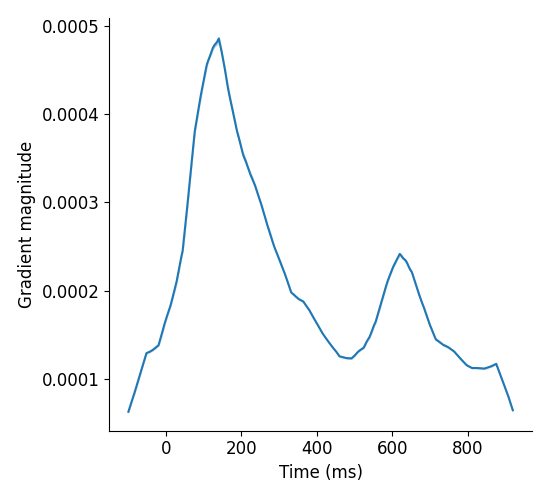

In [24]:
%matplotlib widget
pfi_plot = sns.relplot(
    data=pfits_pd, kind="line",
    x="Time (ms)", y="Gradient magnitude", n_boot=10, legend=None, aspect=1.1
)

plt.tight_layout()
#plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/temporal_PFI.pdf', format='pdf')

In [25]:
plt.savefig('temporal_gradient.pdf', format='pdf', bbox_inches='tight')

In [ ]:
%matplotlib widget
pfi_plot = sns.relplot(
    data=pfi_pd, kind="line", size='channels', style='channels', size_order=['aggregate', 'individual'],
    x="Time (ms)", y="Accuracy loss", hue='relative magnitude', n_boot=10, legend='brief', palette='Reds', aspect=2
)

handles, labels = plt.gca().get_legend_handles_labels()
pfi_plot._legend.remove()
plt.legend(handles[-3:], labels[-3:])

In [ ]:
plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/channelwise_PFI.svg', format='svg')

# Accuracies

In [26]:
df = pd.read_csv('excel_data.txt', sep="\t", header=0)
df = df.stack().reset_index()
df = df.rename(columns={'level_0': 'subject', 'level_1': 'model', 0: 'Validation accuracy'})

model_type = []
for i in range(len(df)):
    if 'finetuned' in df['model'][i]:
        model_type.append('finetuned')
    elif 'emb' in df['model'][i]:
        model_type.append('group\nembedding')
    elif 'group' in df['model'][i]:
        model_type.append('group')
    else:
        model_type.append('subject')
df['model type'] = model_type

In [ ]:
df[df['model']=='nonlin-group-emb']

In [ ]:
%matplotlib widget
'''
rows = df.loc[df['model type'] == 'subject']
g = sns.catplot(kind="violin", data=rows, cut=0, ci=None, scale='width', y='Validation accuracy', x='model')

ax = g.axes[0][0]
ax.axhline(0.008, ls='-', color='black', label='chance')
ax.axhline(0.33, ls='--', color='black', label='peak sliding accuracy')
plt.ylim(0, 1)
plt.legend()
plt.xlabel('')
plt.savefig('/Users/ricsi/GoogleDrive/Projektek/The Brain Project/oxford/writings/neurips_figures/subject_acc.svg', format='svg')
'''

plt.rcParams.update({'font.size': 12})
# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls
plot_params = {
    'kind':    'violin',
    'aspect':  2.1,
    'cut':     0,
    'ci':      None,
    'scale':   'area',
    'hue':     'model type',
    'dodge':   False,
    'data':    df,
    'x':       'model',
    'y':       'Validation accuracy',
    'legend':  None
}

g = sns.catplot(**plot_params)

ax = g.axes[0][0]
ax.axhline(0.008, ls='-', color='black', label='chance')
plt.ylim(0, 1)
plt.xlabel('')
plt.text(7.7,0.015,'chance')
plt.xticks(plt.xticks()[0], ['linear\nsubject',
                             'nonlinear\nsubject',
                             'linear\ngroup',
                             'nonlinear\ngroup',
                             'linear\ngroup-emb',
                             'nonlinear\ngroup-emb',
                             'nonlinear\ngroup\nfinetuned',
                             'nonlinear\ngroup-emb\nfinetuned'])

# add extra padding below plot and to the left of the y-axis
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.1)

ymin = 0.02
ymax = 0.7
alpha = 0.5
dash = '--'
color = 'red'
ax.axvline(1.5, ymin, ymax, ls=dash, color=color, alpha=alpha)
ax.axvline(3.5, ymin, ymax, ls=dash, color=color, alpha=alpha)
ax.axvline(5.5, ymin, ymax, ls=dash, color=color, alpha=alpha)
plt.text(0.22,0.87,'subject models')
plt.text(2,0.8,'group models')
plt.text(3.7,0.8,'group models\nwith embedding')
plt.text(5.6,0.8,'finetuned\ngroup models')

# which pairs to computer stats on
pairs = [('lin-subject', 'nonlin-subject'),
         ('lin-subject', 'nonlin-group-emb'),
         ('lin-subject', 'nonlin-group-emb finetuned'),
         ('nonlin-group-emb', 'nonlin-group-emb finetuned'),
         ('nonlin-group finetuned', 'nonlin-group-emb finetuned'),
         ('nonlin-group-emb', 'nonlin-group')]

# Add statistics annotations
annotator = Annotator(ax, pairs, data=df, x='model', y='Validation accuracy')
annotator.configure(test='Wilcoxon', verbose=True, line_offset_to_group=10).apply_and_annotate()
e=0
plt.savefig('group_acc.pdf', format='pdf')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

naive group-level model vs. proposed group-level model: Wilcoxon test (paired samples), P_val:6.104e-05 Stat=0.000e+00
subject-level models vs. proposed group-level model: Wilcoxon test (paired samples), P_val:2.155e-02 Stat=2.000e+01


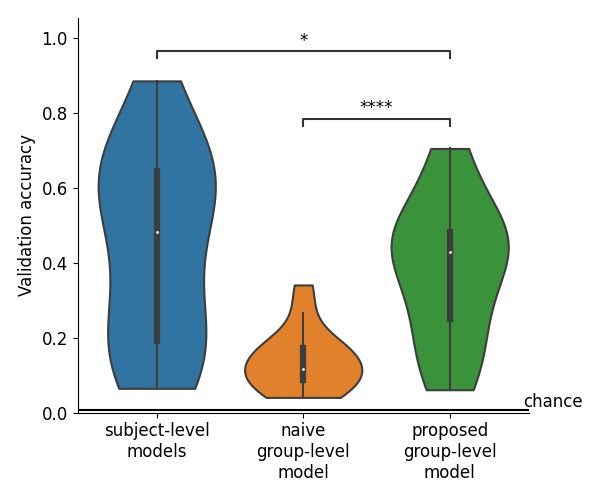

In [36]:
# FOR GRAPHICAL ABSTRACT

df = pd.read_csv('excel_data_abstract.txt', sep="\t", header=0)
df = df.stack().reset_index()
df = df.rename(columns={'level_0': 'subject', 'level_1': 'model', 0: 'Validation accuracy'})

model_type = []
for i in range(len(df)):
    if 'proposed' in df['model'][i]:
        model_type.append('group\nembedding')
    elif 'group' in df['model'][i]:
        model_type.append('group')
    else:
        model_type.append('subject')
df['model type'] = model_type

%matplotlib widget

plt.rcParams.update({'font.size': 12})
# Putting the parameters in a dictionary avoids code duplication
# since we use the same for `sns.boxplot` and `Annotator` calls
plot_params = {
    'kind':    'violin',
    'aspect':  1.2,
    'cut':     0,
    'ci':      None,
    'scale':   'area',
    'hue':     'model type',
    'dodge':   False,
    'data':    df,
    'x':       'model',
    'y':       'Validation accuracy',
    'legend':  None
}

g = sns.catplot(**plot_params)

ax = g.axes[0][0]
ax.axhline(0.008, ls='-', color='black', label='chance')
plt.ylim(0, 1)
plt.xlabel('')
plt.text(2.5,0.015,'chance')
plt.xticks(plt.xticks()[0], ['subject-level\nmodels',
                             'naive\ngroup-level\nmodel',
                             'proposed\ngroup-level\nmodel'])

# add extra padding below plot and to the left of the y-axis
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.1)

ymin = 0.02
ymax = 0.7
alpha = 0.5


# which pairs to computer stats on
pairs = [('subject-level models', 'proposed group-level model'),
         ('naive group-level model', 'proposed group-level model')]

# Add statistics annotations
annotator = Annotator(ax, pairs, data=df, x='model', y='Validation accuracy')
annotator.configure(test='Wilcoxon', verbose=True, line_offset_to_group=10).apply_and_annotate()
e=0
plt.tight_layout()
plt.savefig('group_acc_abstract.pdf', format='pdf')

# Generalization to new subject

In [2]:
# this path should point to the validation accuracy of the subject models
# across all training ratios: 0.1, 0.2, ..., 1.0
path = os.path.join('..', 'results', 'cichy_epoched', 'indiv_wavenetlinear_MNN', 'val_loss_general.npy')
accs = np.load(path)

# this is just a hack to include the results with training ratio 1.0
# as my code does did not save the results for this ratio
train1 = [0.591525424, 0.303672316, 0.121468925, 0.680790966, 0.885593221, 0.662429377, 0.730225995, 0.159604517, 0.579096052, 0.627118642, 0.223163842, 0.151129942, 0.06497175, 0.483050848, 0.412429377]
accs = np.concatenate((accs, np.array(train1).reshape(-1, 1)), axis=1)

# include the chance level
chance = [0.00847] * 15
accs = np.concatenate((np.array(chance).reshape(-1, 1), accs), axis=1)

In [3]:
# create a dataframe for plotting the subject models
accs_df = pd.DataFrame(accs)
accs_df = accs_df.stack().reset_index()

columns = {'level_0': 'subject', 'level_1': 'Training ratio', 0: 'Validation accuracy'}
accs_df = accs_df.rename(columns=columns)

# these correspond to the linear subject results in the paper
accs_df['level'] = ['linear subject'] * len(accs_df)

In [4]:
# helper function to create the dataframe for the group models
def create_df(accsg, level):
    # because of the way the data is saved, we need to reorder the subjects
    order = [10, 7, 3, 11, 8, 4, 12, 9, 5, 13, 1, 14, 2, 6, 0]
    accsg_df = pd.DataFrame(accsg[order, :])
    accsg_df = accsg_df.stack().reset_index()

    columns = {'level_0': 'subject', 'level_1': 'Training ratio', 0: 'Validation accuracy'}
    accsg_df = accsg_df.rename(columns=columns)
    accsg_df['level'] = [level] * len(accsg_df)
    
    return accsg_df

In [5]:
# load LOSO results for nonlinear group-emb
path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_semb_general', 'val_loss_general.txt.npy')
accsg = np.load(path)
group_emb = create_df(accsg, 'nonlinear group-emb')

# load LOSO results for nonlinear group
path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_general', 'val_loss_general.txt.npy')
accsg = np.load(path)
group = create_df(accsg, 'nonlinear group')

'''
path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_semb_general', 'val_loss_subs_general.txt.npy')
accsg = np.mean(np.load(path), axis=2)
group_emb_all = create_df(accsg, 'group-emb all')

path = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_general', 'val_loss_subs_general.txt.npy')
accsg = np.mean(np.load(path), axis=2)
group_all = create_df(accsg, 'group all')
'''

"\npath = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_semb_general', 'val_loss_subs_general.txt.npy')\naccsg = np.mean(np.load(path), axis=2)\ngroup_emb_all = create_df(accsg, 'group-emb all')\n\npath = os.path.join('..', 'results', 'cichy_epoched', 'all_wavenet_general', 'val_loss_subs_general.txt.npy')\naccsg = np.mean(np.load(path), axis=2)\ngroup_all = create_df(accsg, 'group all')\n"

In [6]:
# concatenate the dataframes
df = pd.concat((accs_df, group_emb, group), ignore_index=True)

In [21]:
# compute the p-values between group models across training ratios
p_values = []
for i in range(11):
    test1 = df['Validation accuracy'][(df['Training ratio'] == i) & (df['level'] == 'nonlinear group')]
    test2 = df['Validation accuracy'][(df['Training ratio'] == i) & (df['level'] == 'nonlinear group-emb')]

    p_values.append(stats.ttest_rel(test1, test2)[1] * 11)

# most training ratios are not significant between group models
print(p_values)

# compute the p-values between group models across training ratios
p_values = []
for i in range(11):
    test1 = df['Validation accuracy'][(df['Training ratio'] == i) & (df['level'] == 'linear subject')]
    test2 = df['Validation accuracy'][(df['Training ratio'] == i) & (df['level'] == 'nonlinear group-emb')]

    p_values.append(stats.ttest_rel(test1, test2)[1] * 11)

# most training ratios are not significant between group models
print(p_values)

[2.549255545618082, 0.0731919370389815, 0.012204835542606748, 0.26025862230277796, 3.2764635900767045, 0.02829928939854606, 1.005468169690022, 2.8973173048315384, 0.847682123889208, 0.8483124515747796, 4.308011462846299]
[0.010319437866195208, 0.0007673891808217853, 8.693971214525184e-05, 8.06717954918357e-06, 1.3334426149884462e-05, 8.296803429117595e-05, 0.0019230141067514083, 0.00251109493980509, 0.11839370478059791, 1.3893023132432878, 9.438923323065682]


In [7]:
# divide the training ratio by 10 to get the actual ratio for plotting
df['Training ratio'] = df['Training ratio'].astype(float)/10

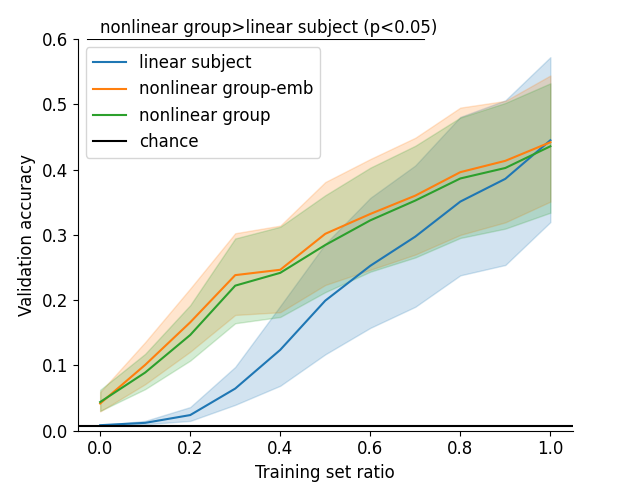

In [13]:
%matplotlib widget
# create figure in paper
g = sns.relplot(
    data=df, kind="line", hue='level',
    x="Training ratio", y="Validation accuracy", n_boot=1000, aspect=0.8, ci=95
)

# delete legend
g._legend.remove()
ax = g.axes[0][0]
plt.axhline(0.6, 0.02, 0.7, color='black')
plt.text(0,0.61,'nonlinear group>linear subject (p<0.05)')
plt.ylim(0, 0.6)
plt.xlabel('Training set ratio')

# chance level for cichy118 data
ax.axhline(0.008, ls='-', color='black', label='chance')
ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig('generalization.pdf', format='pdf', bbox_inches='tight')

# Temporal PFI

In [32]:
# PFIts
path = os.path.join('..',
                    'results',
                    'cichy_epoched',
                    'all_noshuffle_wavenetclass_semb10_drop0.4',
                    'PFIts',
                    'val_loss_PFIts.npy')
pfits = np.load(open(path, 'rb'))
pfits = pfits[0, 0] - pfits

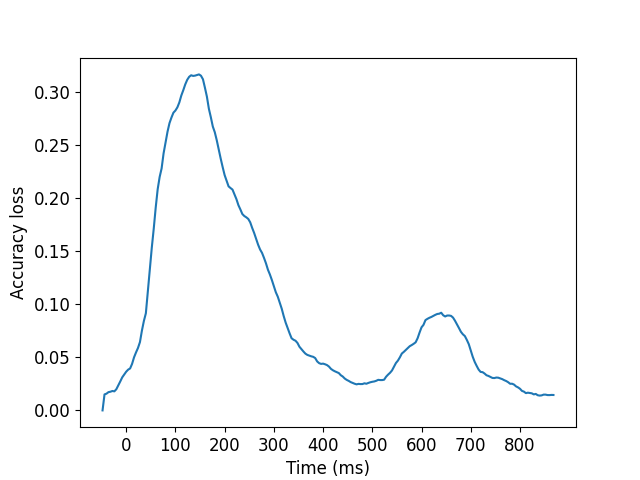

In [40]:
# plot the temporal PFI
%matplotlib widget
plt.figure()
plt.plot(pfits.mean(axis=0))

# axis labels
plt.xlabel('Time (ms)')
plt.ylabel('Accuracy loss')

# x axis ticks
time_range = np.arange(-48, 872, 4)
plt.xticks(np.arange(12, 230, 25), time_range[12::25])
e=0

In [41]:
# any Elekta data path will work here as all we need is the 
# magnetometer channel locations to populate the mne.info object
dataset_path = os.path.join('/',
                            'well',
                            'woolrich',
                            'projects',
                            'cichy118_cont',
                            'raw_data',
                            'subj01',
                            'MEG2_subj01_sess01_tsss_mc-3.fif')
raw = mne.io.read_raw_fif(dataset_path, preload=True)
chn_type = 'mag'
raw = raw.pick(chn_type)

Opening raw data file /well/woolrich/projects/cichy118_cont/raw_data/subj01/MEG2_subj01_sess01_tsss_mc-3.fif...


<ipython-input-41-651ccd40e85a>:11: RuntimeWarning: This filename (/well/woolrich/projects/cichy118_cont/raw_data/subj01/MEG2_subj01_sess01_tsss_mc-3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(dataset_path, preload=True)


    Range : 4930000 ... 5162999 =   4930.000 ...  5162.999 secs
Ready.
Reading 0 ... 232999  =      0.000 ...   232.999 secs...


In [42]:
# this path should point to the output from running spatial PFI on the group model
path = os.path.join('..',
                    'results',
                    'cichy_epoched',
                    'all_noshuffle_wavenetclass_semb10_drop0.4',
                    'PFIch',
                    'val_loss_PFIch1.npy')
pfi_ch1 = np.load(open(path, 'rb'))

# take mean across permutations
pfi_ch1 = np.mean(pfi_ch1, axis=0)
pfi_ch1 = pfi_ch1[0, 0] - pfi_ch1[:, 1:]

In [43]:
# create the evoked object from the spatial PFI results
evoked_ch1 = mne.EvokedArray(pfi_ch1.T, raw.info, tmin=0)

<ipython-input-45-76866bbf654c>:3: FutureWarning: The "vmin" and "vmax" parameters are deprecated and will be removed in version 1.3. Use the "vlim" parameter instead.
  evoked_ch1.plot_topomap(times=[0],


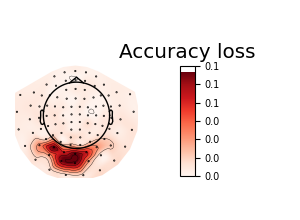

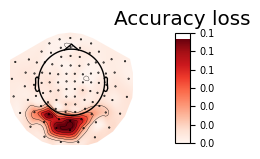

In [45]:
%matplotlib widget
# plot topo map of spatial PFI
evoked_ch1.plot_topomap(times=[0],
                        ch_type='mag',
                        time_unit='ms',
                        scalings=1,
                        units='Accuracy loss',
                        time_format='',
                        vmin=0)